The spelled-out intro to neural networks and backpropagation: building micrograd

https://www.youtube.com/watch?v=VMj-3S1tku0

In [44]:
from __future__ import annotations

import math

import matplotlib.pyplot as plt
import numpy as np
import torch

In [ ]:
def f(x):
    return 2*x**2 + 3*x + 3
f(3)

30

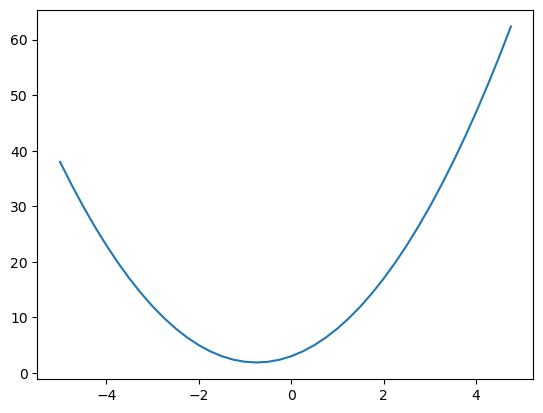

In [3]:
xs = np.arange(-5, 5, 0.25)
ys = f(xs)
plt.plot(xs, ys)

## Derivative
<img src="imgs/derivative.png">

- with what sensitivity does the function respond? 

In [4]:
h = 0.00001
x = 3
(f(x+h) - f(x)) / h

15.00002000014433

In [5]:
h = 0.00000001
x = -4
(f(x+h) - f(x)) / h

-13.00000000981072

In [6]:
h = 0.00001

a = 2
b = -3
c = 4

d1 = a * b + c
a += h
# b += h
# c += h
d2 = a * b + c

(d2 - d1) / h

-3.000000000064062

In [74]:
class Value:
     def __init__(self, data, _children=(), _op='', label='') -> None:
          self.data = data
          self.grad = 0.0
          self._backward = lambda: None
          self._prev = set(_children)
          self._op = _op
          self.label = label

     def __repr__(self) -> str:
          return f"Value(data={self.data})"

     def __add__(self, other: Value) -> Value:
          other = other if isinstance(other, Value) else Value(other)
          out = Value(self.data + other.data, (self, other), "+")
          def _backward():
               self.grad += 1.0 * out.grad
               other.grad += 1.0 * out.grad
          out._backward = _backward
          return out
     
     def __radd__(self, other):
          return self + other
     
     def __sub__(self, other: Value) -> Value:
          return self + -1*other
     
     def __rsub__(self, other):
          return -1*self + other
     
     def __mul__(self, other: Value) -> Value:
          other = other if isinstance(other, Value) else Value(other)
          out = Value(self.data * other.data, (self, other), "*")
          def _backward():
               self.grad += other.data * out.grad
               other.grad += self.data * out.grad
          out._backward = _backward
          return out 
     
     def __rmul__(self, other) -> Value:
          return self * other
     
     def __pow__(self, other):
          assert isinstance(other, (int, float))
          out = Value(self.data**other, (self, ), f"**{other}")
          def _backward():
               self.grad += other * self.data**(other - 1) * out.grad
          out._backward = _backward
          return out
     
     def __truediv__(self, other):
          return self * other**-1
     
     def __rtruediv__(self, other):
          return self**-1 * other
     
     def tanh(self) -> Value:
          x = self.data
          t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
          out = Value(t, (self, ), "tanh")
          def _backward():
               self.grad += (1 - t**2) * out.grad
          out._backward = _backward
          return out
     
     def exp(self):
          x = self.data
          out = Value(math.exp(x), (self, ), 'exp')
          def _backward():
               self.grad += out.data * out.grad
          out._backward = _backward
          return out
     
     def backward(self):
          topo = []
          visited = set()
          def build_topo(v):
               if v not in visited:
                    visited.add(v)
                    for child in v._prev:
                         build_topo(child)
                    topo.append(v)
          build_topo(self)

          self.grad = 1.0
          for node in reversed(topo):
               node._backward()
     
     
print(f"{Value(1) + Value(1) = }")
print(f"{Value(1) + 1 = }")
print(f"{1 + Value(1) = }")

print(f"{Value(2) * Value(3) = }")
print(f"{Value(2) * 3 = }")
print(f"{2 * Value(3) = }")

print(f"{Value(3).exp() = }")

print(f"{Value(2) / Value(3) = }")
print(f"{Value(2) / 3 = }")
print(f"{2 / Value(3) = }")

print(f"{Value(3) ** 2 = }")

print(f"{Value(2) - Value(3) = }")
print(f"{Value(2) - 3 = }")
print(f"{2 - Value(3) = }")


Value(1) + Value(1) = Value(data=2)
Value(1) + 1 = Value(data=2)
1 + Value(1) = Value(data=2)
Value(2) * Value(3) = Value(data=6)
Value(2) * 3 = Value(data=6)
2 * Value(3) = Value(data=6)
Value(3).exp() = Value(data=20.085536923187668)
Value(2) / Value(3) = Value(data=0.6666666666666666)
Value(2) / 3 = Value(data=0.6666666666666666)
2 / Value(3) = Value(data=0.6666666666666666)
Value(3) ** 2 = Value(data=9)
Value(2) - Value(3) = Value(data=-1)
Value(2) - 3 = Value(data=-1)
2 - Value(3) = Value(data=-1)


In [ ]:
a = Value(2.0, label="a")
b = Value(-3.0, label="b")
c = Value(10.0, label="c")
e = a * b; e.label = "e"
d = e + c; d.label = "d"
f = Value(-2.0, label="f")
L = d * f; L.label = "L"
L

In [ ]:
!pip install graphviz
!brew install graphviz

In [42]:
from graphviz import Digraph

def trace(root: Value):
    nodes, edges = set(), set()
    def build(v: Value):
        nodes.add(v)
        for child in v._prev:
            edges.add((child, v))
            build(child)
    build(root)
    return nodes, edges

def draw_dot(root: Value):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # left to right
    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        dot.node(name=uid, label="{%s | data %.4f | grad %.4f}" % (n.label, n.data, n.grad), shape='record')
        if n._op:
            dot.node(name=uid+n._op, label=n._op)
            dot.edge(uid+n._op, uid)
    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)

    return dot

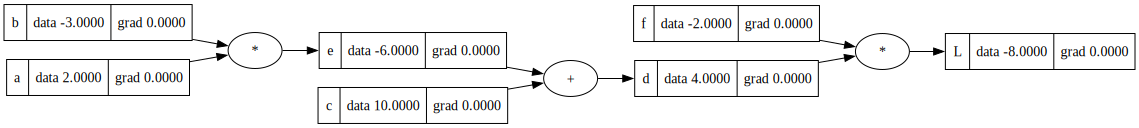

In [43]:
draw_dot(L)

In [54]:

# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'

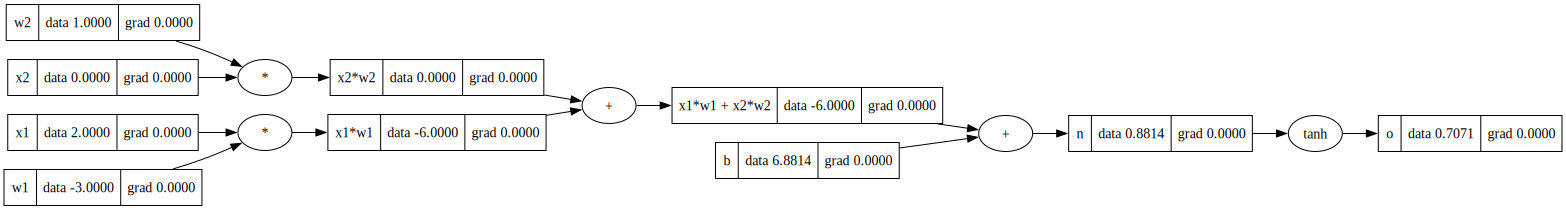

In [49]:
draw_dot(o)

## Topological graph
- linear order of dependencies
- makes sure all children are in graph and then appends itself

In [50]:
topo = []
visited = set()
def build_topo(v):
    if v not in visited:
        visited.add(v)
        for child in v._prev:
            build_topo(child)
        topo.append(v)
build_topo(o)
topo

[Value(data=6.881373587019543),
 Value(data=-3.0),
 Value(data=2.0),
 Value(data=-6.0),
 Value(data=0.0),
 Value(data=1.0),
 Value(data=0.0),
 Value(data=-6.0),
 Value(data=0.8813735870195432),
 Value(data=0.7071067811865476)]

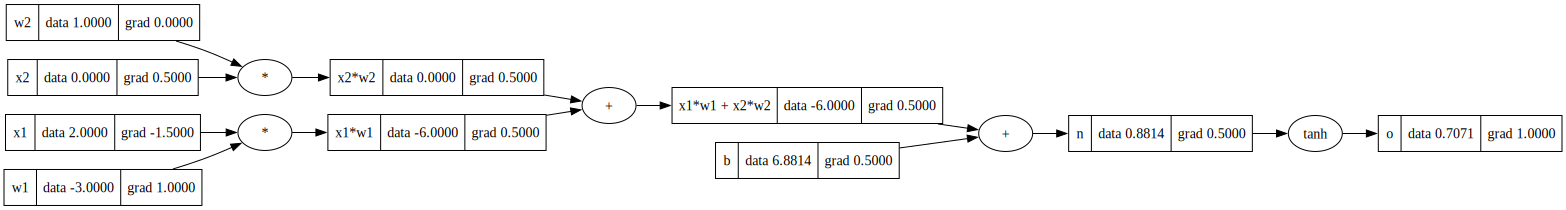

In [52]:
o.grad = 1
for node in reversed(topo):
    node._backward()

draw_dot(o)

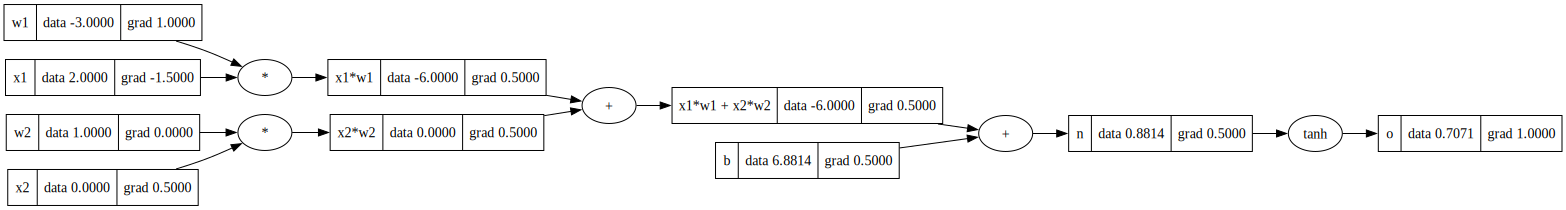

In [58]:
o.backward()
draw_dot(o)

## tanh
![image.png](imgs/tanh.png)

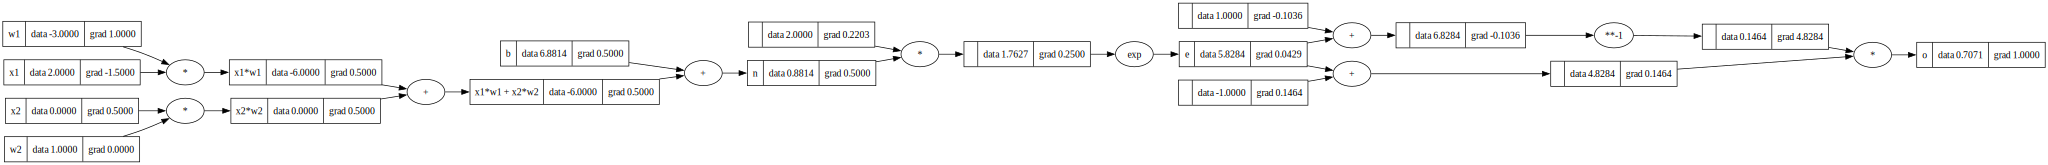

In [76]:
# Redefine o to expand tanh
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
# o = n.tanh(); o.label = 'o'
e = (2*n).exp(); e.label = 'e'
o = (e-1) / (e+1); o.label = 'o'
o.backward()
draw_dot(o)
# equal final gradients
